# A Study on Gradient Boosting Algorithms and Hyperparameter Optimization using Optuna

Undergraduate Thesis submitted to the Undergraduate Course in Mechatronics Engineering from São Carlos School of Engineering, University of São Paulo – EESC- USP, in partial fulfillment of the requirements for the bachelor degree in Mechatronics Engineer .

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import timeit
import gc
import sklearn
import seaborn
from sklearn import metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
import shap
import validation_train
from validation_train import auc_logloss_ks
from validation_train import objective
from validation_train import tuning
from validation_train import train
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# 1.0 - Diabetes Dataset 

[Diabetes Dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set)

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

In [2]:
# load the dataset
df_diabete = pd.read_csv('01_diabetes_dataset.csv')
df_diabete

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.000,no,no,8,6,no,occasionally,sometimes,high,0.000,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.000,no,no,8,6,yes,very often,sometimes,normal,0.000,0,not much,no
2,40-49,Male,no,no,one hr or more,24.000,no,no,6,6,no,occasionally,sometimes,normal,0.000,0,not much,no
3,50-59,Male,no,no,one hr or more,23.000,no,no,8,6,no,occasionally,sometimes,normal,0.000,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.000,no,no,8,8,no,occasionally,sometimes,normal,0.000,0,not much,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,less than 40,Male,yes,no,more than half an hr,25.000,no,no,8,6,no,often,sometimes,normal,0.000,0,not much,yes
948,60 or older,Male,yes,yes,more than half an hr,27.000,no,no,6,5,yes,occasionally,sometimes,high,0.000,0,quite often,yes
949,60 or older,Male,no,yes,none,23.000,no,no,6,5,yes,occasionally,sometimes,high,0.000,0,not much,no
950,60 or older,Male,no,yes,less than half an hr,27.000,no,yes,6,5,yes,occasionally,very often,high,0.000,0,not much,no


In [3]:
# name of columns
df_diabete.columns

Index(['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'BMI',
       'Smoking', 'Alcohol', 'Sleep', 'SoundSleep', 'RegularMedicine',
       'JunkFood', 'Stress', 'BPLevel', 'Pregancies', 'Pdiabetes',
       'UriationFreq', 'Diabetic'],
      dtype='object')

In [4]:
# type of columns
df_diabete.dtypes

Age                  object
Gender               object
Family_Diabetes      object
highBP               object
PhysicallyActive     object
BMI                 float64
Smoking              object
Alcohol              object
Sleep                 int64
SoundSleep            int64
RegularMedicine      object
JunkFood             object
Stress               object
BPLevel              object
Pregancies          float64
Pdiabetes            object
UriationFreq         object
Diabetic             object
dtype: object

In [5]:
# Descriptive statistics 
df_diabete.describe()

,BMI,Sleep,SoundSleep,Pregancies
count,948.000,952.000,952.000,910.000
mean,25.764,6.950,5.496,0.387
std,5.403,1.273,1.866,0.909
min,15.000,4.000,0.000,0.000
25%,22.000,6.000,4.000,0.000
50%,25.000,7.000,6.000,0.000
75%,29.000,8.000,7.000,0.000
max,45.000,11.000,11.000,4.000


In [6]:
# number o NaN in each column
df_diabete.isna().sum()

Age                  0
Gender               0
Family_Diabetes      0
highBP               0
PhysicallyActive     0
BMI                  4
Smoking              0
Alcohol              0
Sleep                0
SoundSleep           0
RegularMedicine      0
JunkFood             0
Stress               0
BPLevel              0
Pregancies          42
Pdiabetes            1
UriationFreq         0
Diabetic             1
dtype: int64

In [7]:
df_diabete.loc[df_diabete['BMI'].isna()]

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
113,less than 40,Female,yes,no,more than half an hr,NaN,no,no,7,6,no,occasionally,not at all,normal,0.000,0,not much,NaN
116,less than 40,Female,no,no,more than half an hr,NaN,no,no,5,4,no,often,very often,normal,0.000,0,not much,no
121,50-59,Female,yes,yes,none,NaN,no,no,6,3,yes,occasionally,always,high,2.000,0,not much,yes
122,less than 40,Male,no,yes,more than half an hr,NaN,no,no,6,6,no,occasionally,sometimes,normal,0.000,0,quite often,no


In [8]:
df_diabete.loc[df_diabete['Pregancies'].isna()]

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
136,less than 40,Male,yes,no,more than half an hr,21.000,yes,no,8,8,no,occasionally,very often,normal,NaN,0,not much,no
137,less than 40,Female,yes,no,one hr or more,26.000,no,no,7,5,no,often,sometimes,Low,NaN,no,not much,no
138,less than 40,Female,yes,no,none,21.000,no,yes,9,8,no,occasionally,sometimes,normal,NaN,0,not much,no
139,less than 40,Female,yes,no,none,21.000,no,yes,8,8,no,occasionally,sometimes,normal,NaN,0,not much,no
140,less than 40,Female,yes,no,more than half an hr,24.000,no,no,8,8,yes,often,sometimes,normal,NaN,0,quite often,no
141,less than 40,Male,no,no,more than half an hr,24.000,yes,yes,7,6,no,often,sometimes,normal,NaN,0,not much,no
142,less than 40,Male,no,no,less than half an hr,26.000,no,yes,6,4,no,occasionally,very often,normal,NaN,0,not much,no
143,50-59,Male,yes,no,less than half an hr,32.000,no,no,8,4,yes,occasionally,sometimes,normal,NaN,0,not much,no
144,40-49,Male,yes,no,more than half an hr,34.000,no,no,7,5,no,often,sometimes,normal,NaN,0,quite often,no
145,less than 40,Male,no,no,more than half an hr,30.000,no,no,7,4,no,occasionally,sometimes,normal,NaN,0,not much,no


In [9]:
df_diabete.loc[df_diabete['Diabetic'].isna()]

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
113,less than 40,Female,yes,no,more than half an hr,NaN,no,no,7,6,no,occasionally,not at all,normal,0.000,0,not much,NaN


In [10]:
df_diabete['Age'].value_counts()

less than 40    488
40-49           164
50-59           156
60 or older     144
Name: Age, dtype: int64

In [11]:
df_diabete['Gender'].value_counts()

Male      580
Female    372
Name: Gender, dtype: int64

In [12]:
df_diabete['Family_Diabetes'].value_counts()

no     498
yes    454
Name: Family_Diabetes, dtype: int64

In [13]:
df_diabete['highBP'].value_counts()

no     724
yes    228
Name: highBP, dtype: int64

In [14]:
df_diabete['PhysicallyActive'].value_counts()

less than half an hr    336
more than half an hr    272
one hr or more          212
none                    132
Name: PhysicallyActive, dtype: int64

In [15]:
df_diabete['Smoking'].value_counts()

no     844
yes    108
Name: Smoking, dtype: int64

In [16]:
df_diabete['RegularMedicine'].value_counts()

no     615
yes    336
o        1
Name: RegularMedicine, dtype: int64

In [17]:
df_diabete['JunkFood'].value_counts()

occasionally    672
often           184
very often       52
always           44
Name: JunkFood, dtype: int64

In [18]:
df_diabete['Stress'].value_counts()

sometimes     564
very often    164
not at all    136
always         88
Name: Stress, dtype: int64

In [19]:
df_diabete['BPLevel'].value_counts()

normal     707
high       211
low         25
High         5
Low          3
normal       1
Name: BPLevel, dtype: int64

In [20]:
df_diabete['UriationFreq'].value_counts()

not much       664
quite often    288
Name: UriationFreq, dtype: int64

In [21]:
df_diabete['Diabetic'].value_counts()

no     684
yes    266
 no      1
Name: Diabetic, dtype: int64

In [3]:
# correcting the strin 'no'
df_diabete['RegularMedicine'].replace('o', 'no', inplace =True)
df_diabete['Diabetic'].replace(' no', 'no', inplace =True)

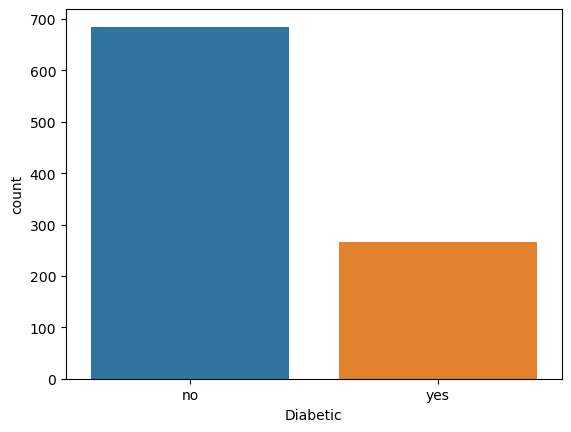

In [23]:
seaborn.countplot(x = 'Diabetic',data = df_diabete)
plt.savefig('diabete_tot.png')

In [4]:
cols_cat_diabete = ['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive',
       'Smoking', 'Alcohol', 'RegularMedicine',
       'JunkFood', 'Stress', 'BPLevel', 'Pregancies', 'Pdiabetes',
       'UriationFreq']

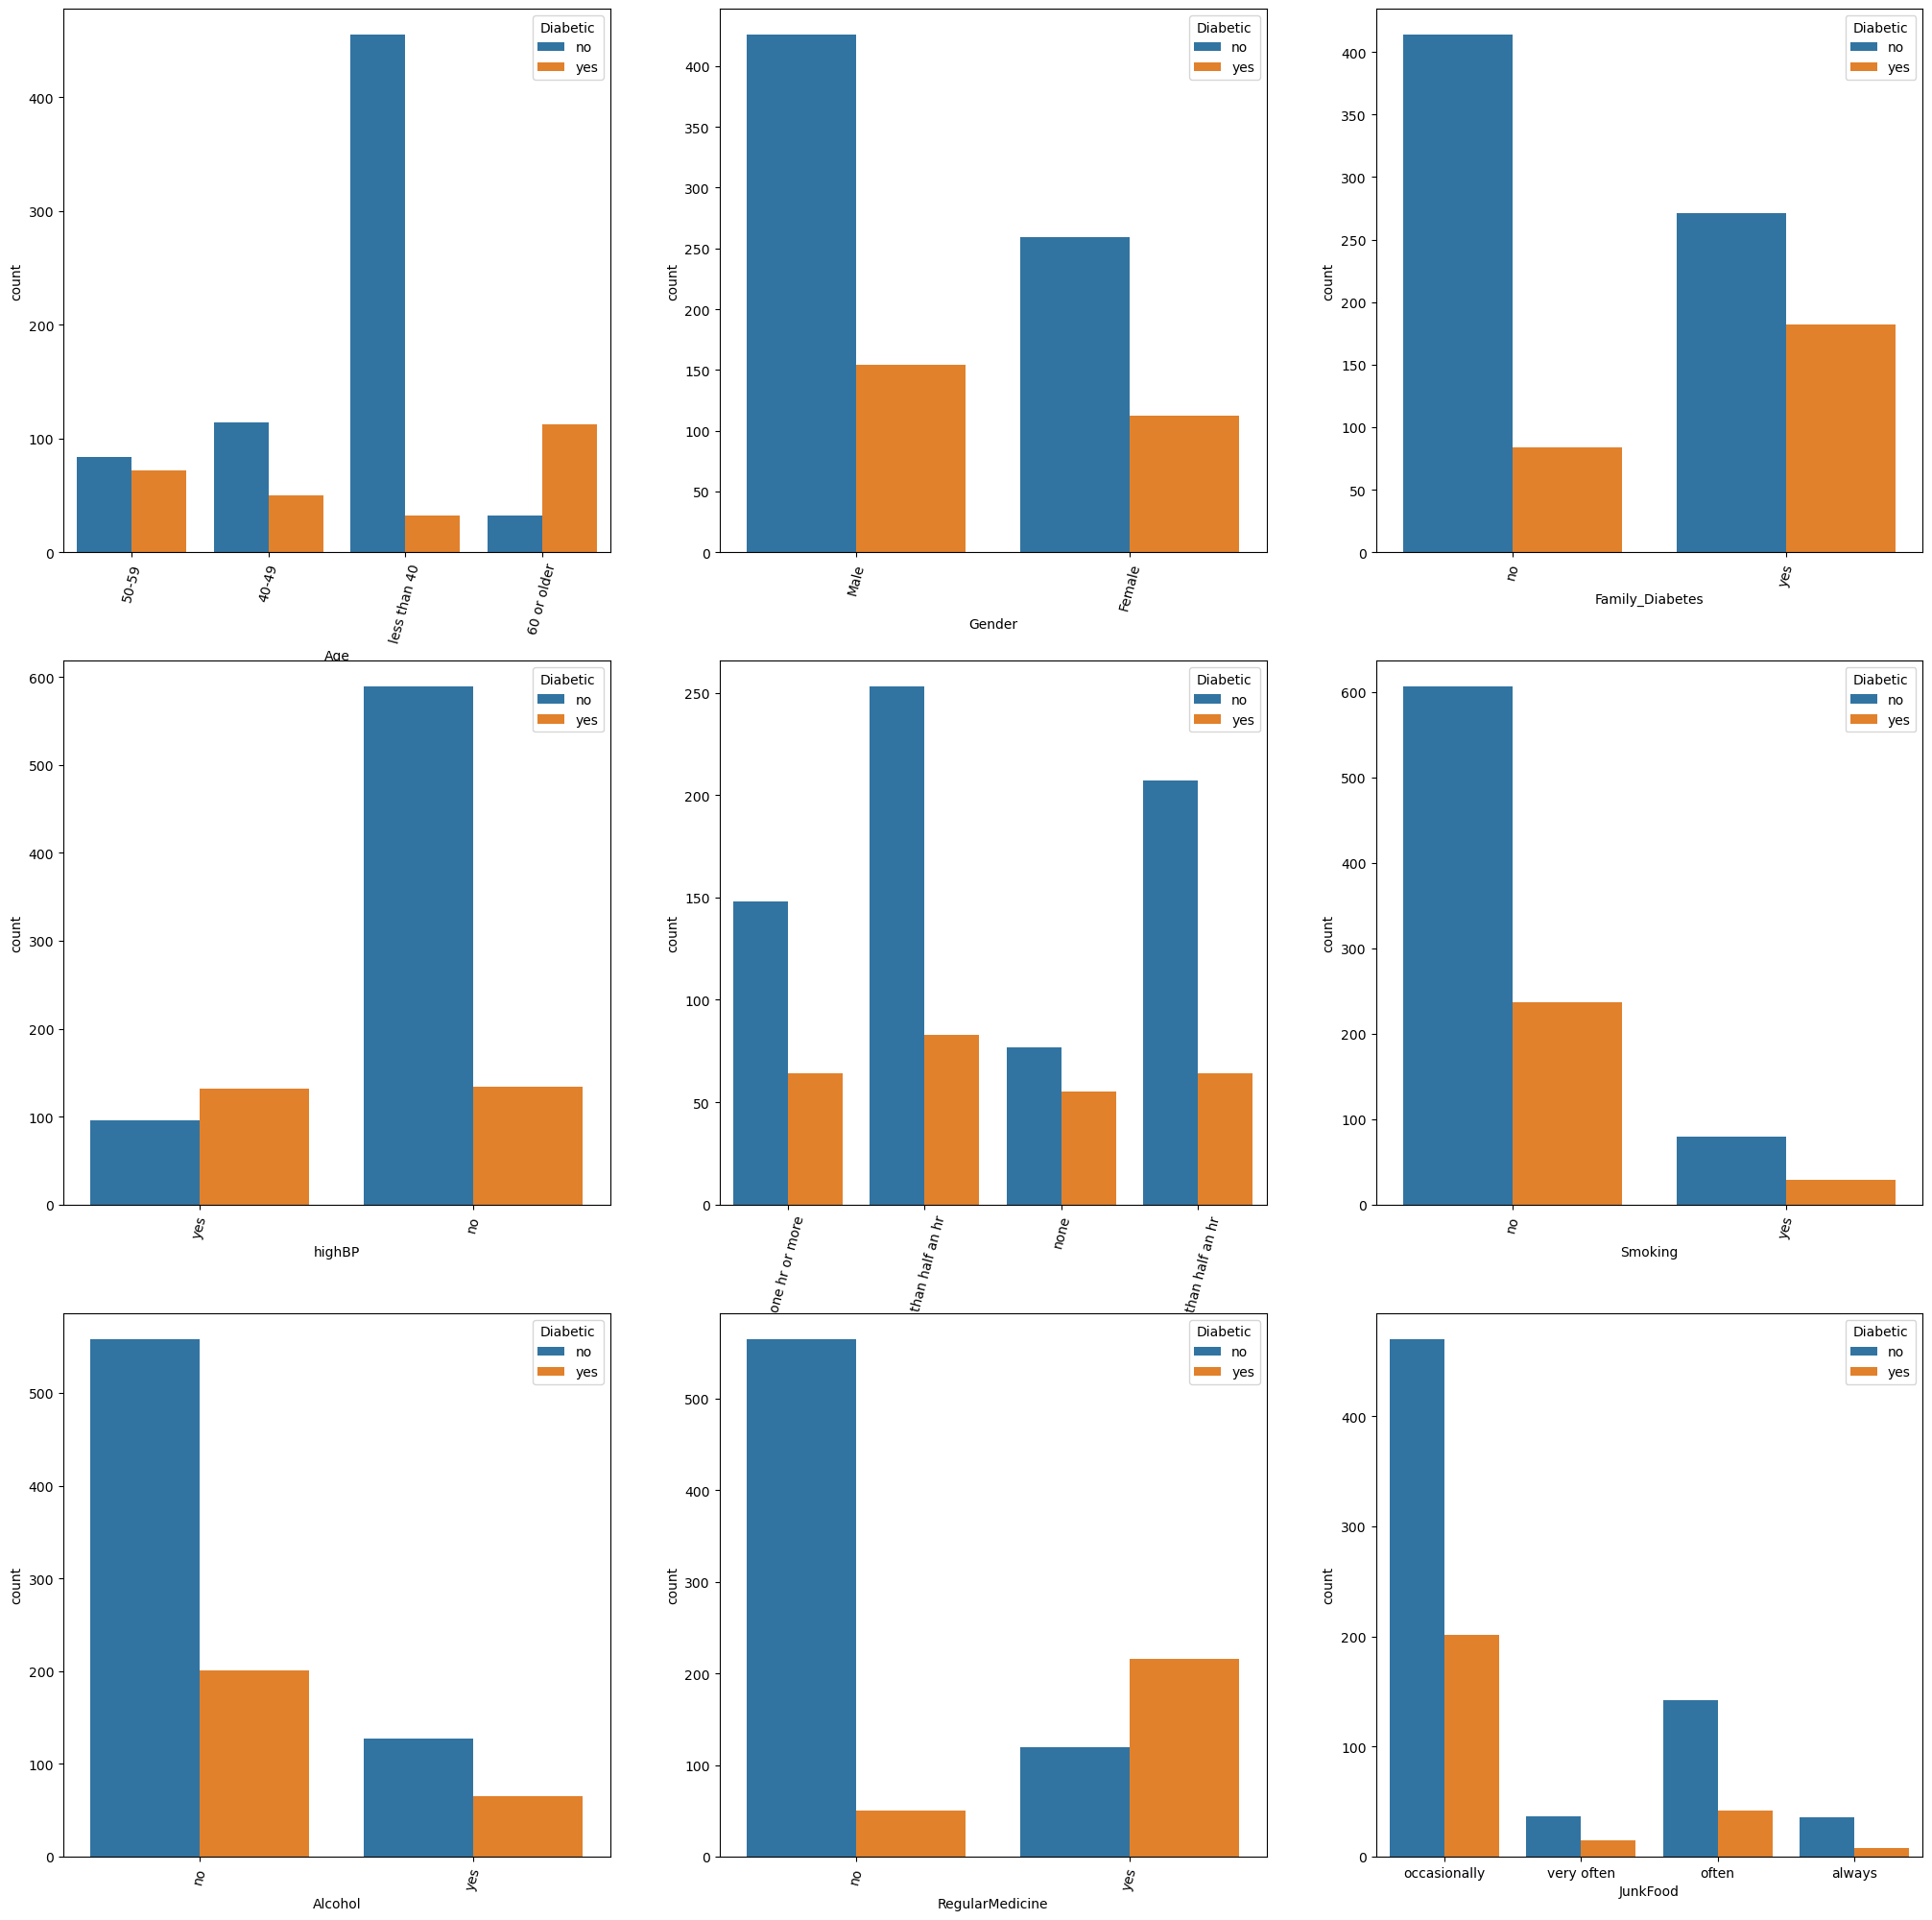

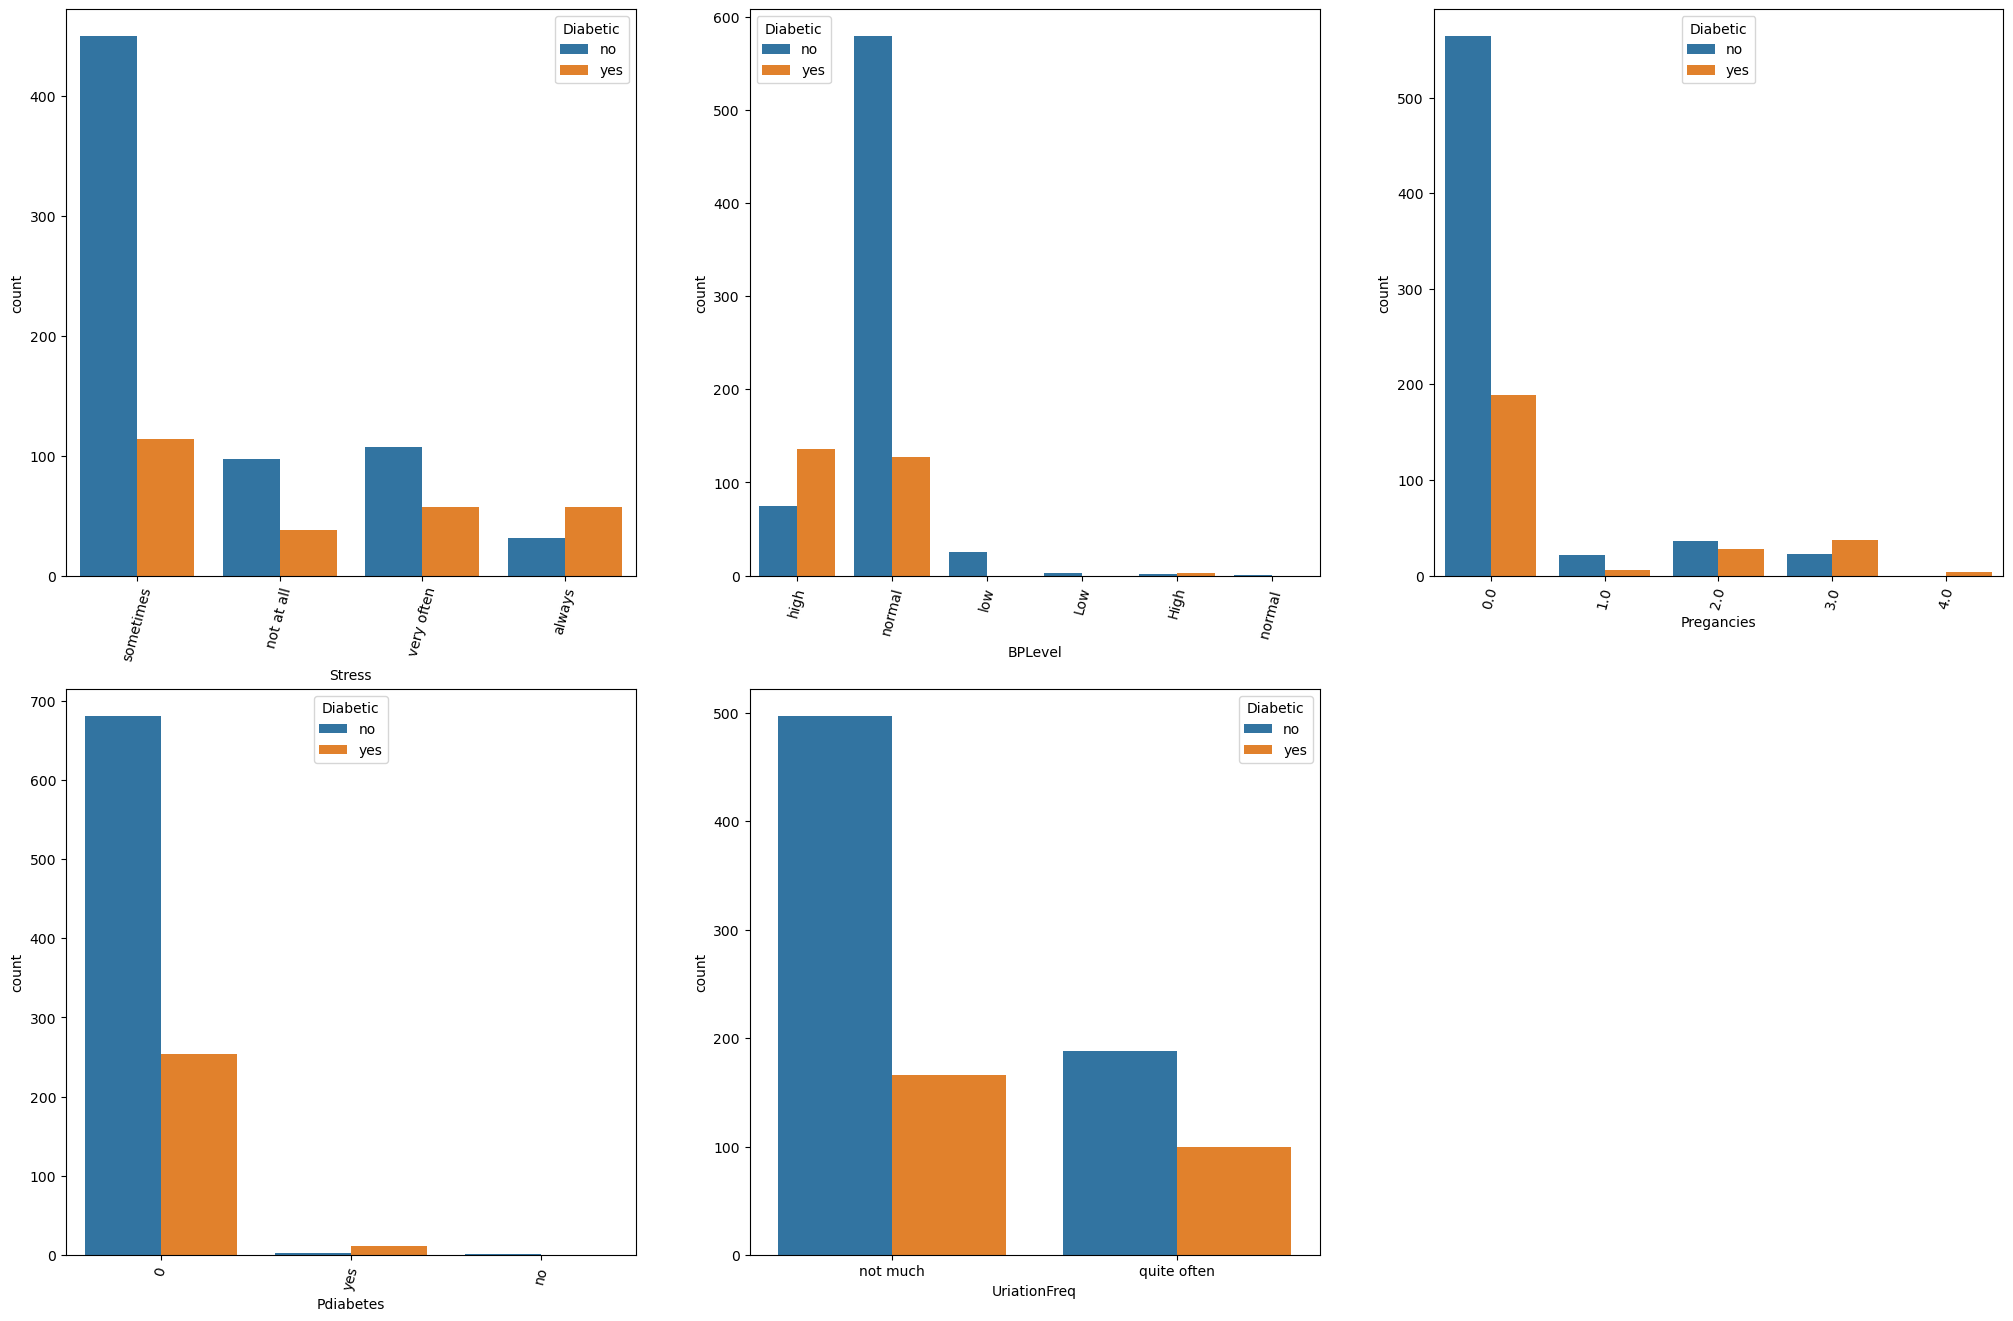

In [25]:
plt.figure(figsize = (25,25))

i  = 0
for j in range(9):
    plt.xticks(rotation=75)
    plt.subplot(int(str(3)+str(3)+str(j+1)))
    seaborn.countplot(x = cols_cat_diabete[i], hue='Diabetic',data = df_diabete)
    i += 1

    
plt.figure(figsize = (25,25))
for j in range(5):
    plt.xticks(rotation=75)
    plt.subplot(int(str(3)+str(3)+str(j+1)))
    seaborn.countplot(x = cols_cat_diabete[i], hue='Diabetic',data = df_diabete)
    i += 1
    

<Figure size 2500x2500 with 0 Axes>

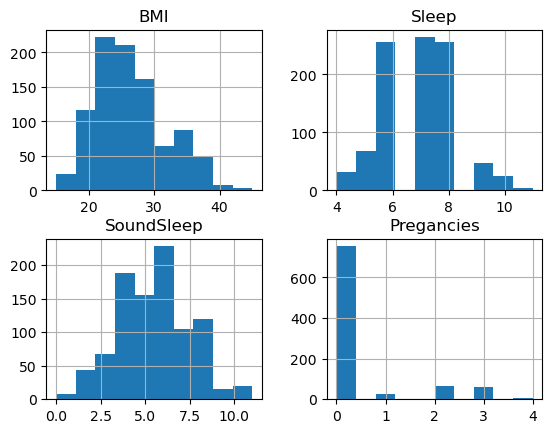

In [26]:
plt.figure(figsize = (25,25))
df_diabete.hist()
plt.savefig('hist_diabete_pop.png')

<Figure size 2500x2500 with 0 Axes>

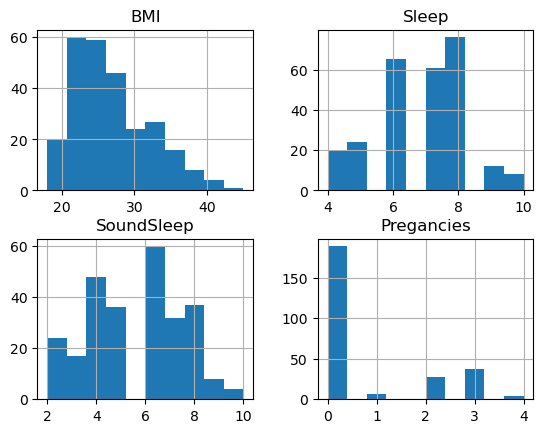

In [27]:
plt.figure(figsize = (25,25))
df_diabete.loc[df_diabete['Diabetic']=='yes'].hist()
plt.savefig('hist_diabete_yes.png')

<Figure size 2500x2500 with 0 Axes>

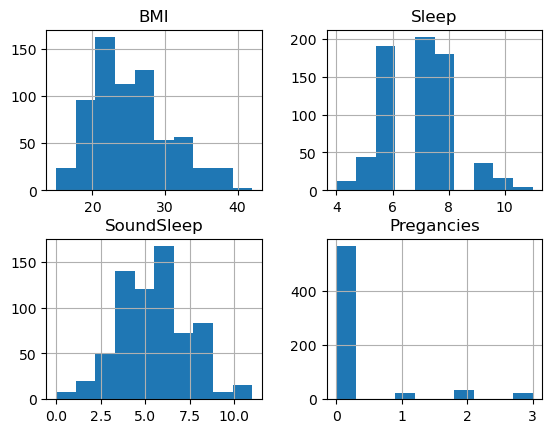

In [28]:
plt.figure(figsize = (25,25))
df_diabete.loc[df_diabete['Diabetic']=='no'].hist()
plt.savefig('hist_diabete_no.png')

In [5]:
# convert cat to numeric
df_diabete_conv = df_diabete.copy()

In [6]:
df_diabete_conv = pd.get_dummies(df_diabete_conv, drop_first= True)
df_diabete_conv

,BMI,Sleep,SoundSleep,Pregancies,Age_50-59,Age_60 or older,Age_less than 40,Gender_Male,Family_Diabetes_yes,highBP_yes,...,Stress_very often,BPLevel_Low,BPLevel_high,BPLevel_low,BPLevel_normal,BPLevel_normal,Pdiabetes_no,Pdiabetes_yes,UriationFreq_quite often,Diabetic_yes
0,39.000,8,6,0.000,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
1,28.000,8,6,0.000,1,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2,24.000,6,6,0.000,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,23.000,8,6,0.000,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,27.000,8,8,0.000,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,25.000,8,6,0.000,0,0,1,1,1,0,...,0,0,0,0,1,0,0,0,0,1
948,27.000,6,5,0.000,0,1,0,1,1,1,...,0,0,1,0,0,0,0,0,1,1
949,23.000,6,5,0.000,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
950,27.000,6,5,0.000,0,1,0,1,0,1,...,1,0,1,0,0,0,0,0,0,0


In [10]:
df_diabete_conv.columns

Index(['BMI', 'Sleep', 'SoundSleep', 'Pregancies', 'Age_50-59',
       'Age_60 or older', 'Age_less than 40', 'Gender_Male',
       'Family_Diabetes_yes', 'highBP_yes',
       'PhysicallyActive_more than half an hr', 'PhysicallyActive_none',
       'PhysicallyActive_one hr or more', 'Smoking_yes', 'Alcohol_yes',
       'RegularMedicine_yes', 'JunkFood_occasionally', 'JunkFood_often',
       'JunkFood_very often', 'Stress_not at all', 'Stress_sometimes',
       'Stress_very often', 'BPLevel_Low', 'BPLevel_high', 'BPLevel_low',
       'BPLevel_normal', 'BPLevel_normal ', 'Pdiabetes_no', 'Pdiabetes_yes',
       'UriationFreq_quite often', 'Diabetic_yes'],
      dtype='object')

## XGBoost

In [7]:
df_diabete_conv = df_diabete_conv.rename(columns={'Diabetic_yes': 'target'})

In [8]:
var_cols = df_diabete_conv.drop(columns='target').columns

In [9]:
var_cols

Index(['BMI', 'Sleep', 'SoundSleep', 'Pregancies', 'Age_50-59',
       'Age_60 or older', 'Age_less than 40', 'Gender_Male',
       'Family_Diabetes_yes', 'highBP_yes',
       'PhysicallyActive_more than half an hr', 'PhysicallyActive_none',
       'PhysicallyActive_one hr or more', 'Smoking_yes', 'Alcohol_yes',
       'RegularMedicine_yes', 'JunkFood_occasionally', 'JunkFood_often',
       'JunkFood_very often', 'Stress_not at all', 'Stress_sometimes',
       'Stress_very often', 'BPLevel_Low', 'BPLevel_high', 'BPLevel_low',
       'BPLevel_normal', 'BPLevel_normal ', 'Pdiabetes_no', 'Pdiabetes_yes',
       'UriationFreq_quite often'],
      dtype='object')

In [10]:
X = df_diabete_conv.loc[:,var_cols]
y = df_diabete_conv.loc[:,'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((666, 30), (286, 30), (666,), (286,))

In [128]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda': 0.05
}

In [129]:
XGBoost_class = XGBClassifier(**parameters)

In [130]:
start = timeit.default_timer()
XGBoost_model = XGBoost_class.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

0.10511741200025426

In [131]:
y_prob = XGBoost_model.predict(X_test)

In [132]:
auc_logloss_ks(y_test, y_prob)

(0.9259751773049645, 2.1737915100973217, 0.8519503546099291)

### XGBoost using optuna

In [ ]:
XGBoost_model, study_xgb = train(X_train, y_train, X_test, y_test, balanced='balanced', method='XGBoost')

In [1]:
optuna.visualization.plot_optimization_history(study_xgb)


In [2]:
optuna.visualization.plot_param_importances(study_xgb)

In [3]:
optuna.visualization.plot_slice(study_xgb, ['min_child_weight'])

In [4]:
optuna.visualization.plot_slice(study_xgb, ['learning_rate'])

In [5]:
optuna.visualization.plot_slice(study_xgb, ['max_depth'])

In [6]:
optuna.visualization.plot_slice(study_xgb, ['lambda'])

## CatBoost

In [20]:
df_diabete.columns

Index(['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'BMI',
       'Smoking', 'Alcohol', 'Sleep', 'SoundSleep', 'RegularMedicine',
       'JunkFood', 'Stress', 'BPLevel', 'Pregancies', 'Pdiabetes',
       'UriationFreq', 'Diabetic'],
      dtype='object')

In [13]:
col_cat = df_diabete.drop(columns='Diabetic').columns

In [14]:
df_diabete.loc[df_diabete['Diabetic']=='yes','target']=1

In [15]:
df_diabete = df_diabete.fillna(0)

In [16]:
df_diabete = df_diabete.drop(columns='Diabetic')

In [17]:
X = df_diabete.loc[:,col_cat]
y = df_diabete.loc[:,'target']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat.shape, X_test_cat.shape, y_train_cat.shape, y_test_cat.shape 

((666, 17), (286, 17), (666,), (286,))

In [18]:
categorical_features_indices = list(X_train_cat.select_dtypes(exclude='number').columns)

In [29]:
parameters = {
        'learning_rate': 0.3,
        'depth': 3,
        'l2_leaf_reg': 0.05
}

In [30]:
CatBoost_Classifier = CatBoostClassifier(**parameters)

In [31]:
# Fit model
start = timeit.default_timer()
CatBoost_model = CatBoost_Classifier.fit(X_train_cat, y_train_cat,cat_features=categorical_features_indices,verbose=False)
stop = timeit.default_timer()
stop - start

1.1427897630001098

In [167]:
y_prob = CatBoost_model.predict(X_test_cat)

In [168]:
auc_logloss_ks(y_test_cat, y_prob)

(0.9049202127659575, 2.89839240785671, 0.8098404255319149)

## CatBoost using Optuna

In [ ]:
CatBoost_model, study_cat = train(X_train_cat, y_train_cat, X_test_cat, y_test_cat, balanced='balanced', method='CATBoost')

In [7]:
# optuna.visualization.plot_optimization_history(study_cat)

In [8]:
# optuna.visualization.plot_param_importances(study_cat)

In [9]:
# optuna.visualization.plot_slice(study_cat, ['depth'])

In [10]:
# optuna.visualization.plot_slice(study_cat, ['learning_rate'])

In [11]:
# optuna.visualization.plot_slice(study_cat, ['od_wait'])

In [12]:
# optuna.visualization.plot_slice(study_cat, ['l2_leaf_reg'])

## LightGBM

In [199]:
parameters = {
        'learning_rate': 0.3,
        'max_depth': 3,
        'lambda_l2': 0.05
}

In [200]:
LGBM_Classifier = LGBMClassifier(**parameters)

In [201]:
start = timeit.default_timer()
LGBM_model = LGBM_Classifier.fit(X_train, y_train)
stop = timeit.default_timer()
stop - start

0.09689930400054436

In [246]:
y_prob = LGBM_model.predict(X_test)

In [247]:
auc_logloss_ks(y_test,y_prob)

(0.9310726950354609, 1.8114854696272071, 0.862145390070922)

## LGBM using Optuna

In [ ]:
LGBM_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

In [13]:
# optuna.visualization.plot_optimization_history(study_lgbm)

In [14]:
# optuna.visualization.plot_param_importances(study_lgbm)

In [15]:
# optuna.visualization.plot_slice(study_lgbm, ['lambda_l1'])

In [16]:
# optuna.visualization.plot_slice(study_lgbm, ['learning_rate'])

In [17]:
# optuna.visualization.plot_slice(study_lgbm, ['min_data_in_leaf'])

In [18]:
# optuna.visualization.plot_slice(study_lgbm, ['max_depth'])

# SHAP for model with best perfom

In [26]:
explainer = shap.TreeExplainer(LGBM_model)

In [27]:
shap_values = explainer.shap_values(X_train)

In [37]:
explainer = shap.TreeExplainer(LGBM_model)
shap_values = explainer.shap_values(X_train)

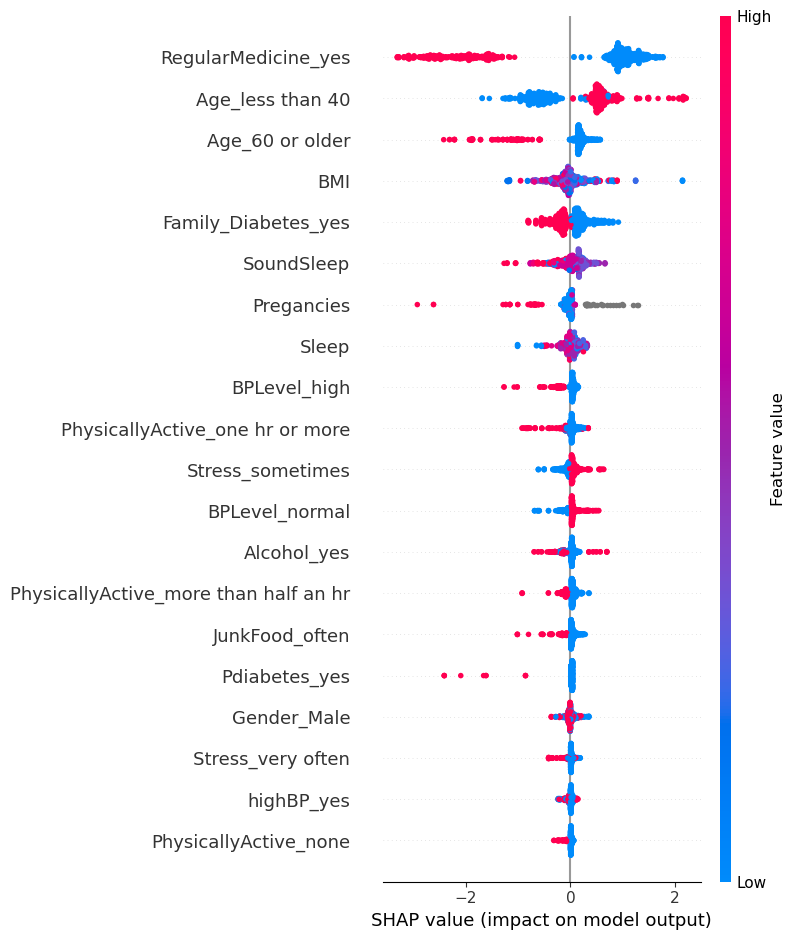

In [38]:
shap.summary_plot(shap_values[0], X_train,show=False)

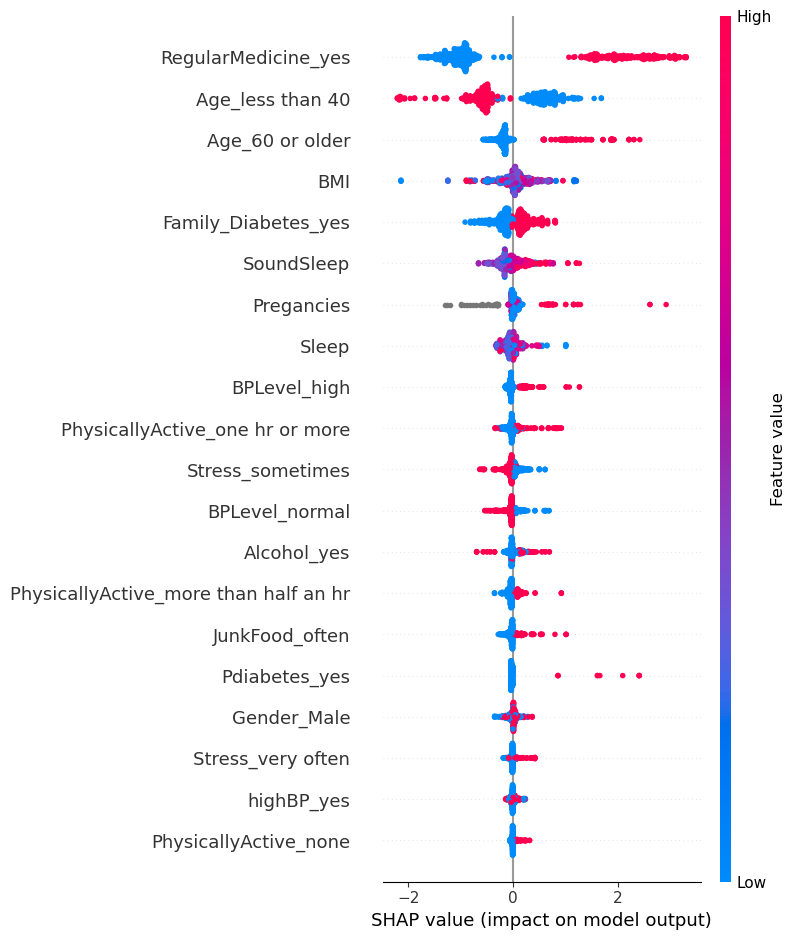

In [41]:
shap.summary_plot(shap_values[1], X_train,show=False)
plt.savefig('shap_lgbm_diabete.png')

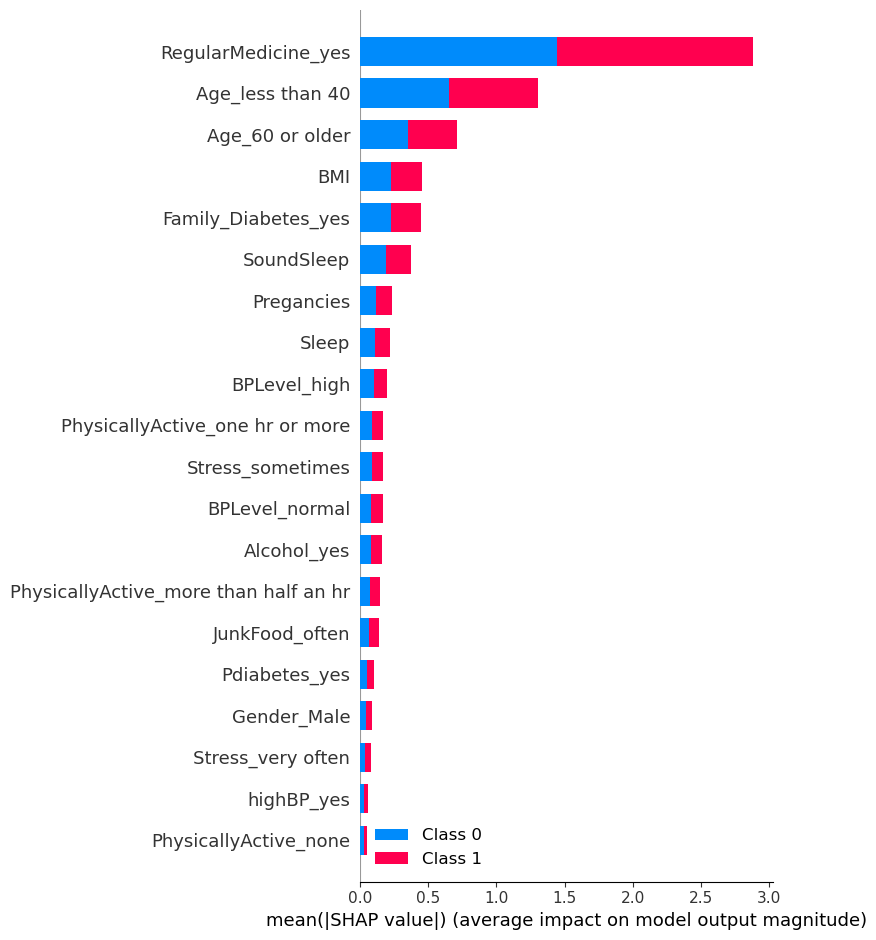

In [40]:
shap.summary_plot(shap_values, X_train,show=False)

## Default results

||	XGBoost	|CatBoost	|LightGBM|
|---|---|---|---|
AUC	|0.93639|	0.89655|	0.92066|
logloss	|1.69072	|2.65684	|2.29456|
KS	|0.87278	|0.79311|	0.84131|
time (s)	|0.17799	|1.78698	|0.08261|

## Optuna results (30min tuning for each model)

||	XGBoost|	CatBoost|	LightGBM|
|---|---|---|---|
AUC	|0.97595	|0.981106	|0.98066|
logloss	|0.173|	0.17327	|0.18599|
KS	|0.87821	|0.87799	|0.8832|